# Loss Landscape
In this notebook we plot the loss landscape of the models to see how it is efffected by the quantization and see the correlation between some metrics and the robustnmess of the model.

In [147]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from pylab import *
import os
import sys
import torch
import pandas as pd
import numpy as np
import pickle

import loss_landscapes
import loss_landscapes.metrics


Build the dataset by merging all the analysis

In [148]:
df_noise = pd.read_csv('./results/econ/noise.csv')
df_cka = pd.read_csv('./results/econ/cka.csv')
df_fisher = pd.read_csv('./results/econ/fisher.csv')
df_neural_efficiency = pd.read_csv('./results/econ/neural_efficiency.csv')

In [149]:
df_cka = df_cka[['precision', 'batch_size', 'learning_rate', 'avg_cka']]
df_fisher = df_fisher[['precision', 'batch_size', 'learning_rate', 'avg_EF']]
df_neural_efficiency = df_neural_efficiency[['precision', 'batch_size', 'learning_rate', 'net_efficiency']]
dataset_df = pd.merge(df_noise, df_cka, on=['precision', 'batch_size', 'learning_rate'])
dataset_df = pd.merge(dataset_df, df_fisher, on=['precision', 'batch_size', 'learning_rate'])
dataset_df = pd.merge(dataset_df, df_neural_efficiency, on=['precision', 'batch_size', 'learning_rate'])
dataset_df.head()

precision        emd   noise 5%  noise 10%  noise 15%  noise 20%  \
0          3  13.756807   0.000007  -0.002073  -0.004534  -0.007646   
1          3  13.756806  -0.050717  -0.131244  -0.160977  -0.143070   
2          3   6.588415 -41.237067 -39.686246 -38.184796 -37.028256   
3          3   2.931284  -6.072095   5.701550  15.875856  23.917104   
4          3   1.967709   9.590914  31.739590  52.735315  69.943284   

   batch_size  learning_rate   avg_cka    avg_EF  net_efficiency  
0          16        0.10000  0.997355  0.000000        0.000055  
1          16        0.05000  0.997567  0.000000        0.000343  
2          16        0.02500  0.845989  0.362840        0.130907  
3          16        0.01250  0.976874  0.002718        0.415456  
4          16        0.00625  0.955943  0.021407        0.459499

In [150]:
dataset_df.to_csv('./results/econ/dataset.csv', index=False)

# Correlation between robustness and metrics

In [151]:
correlation_matrix = dataset_df.corr()

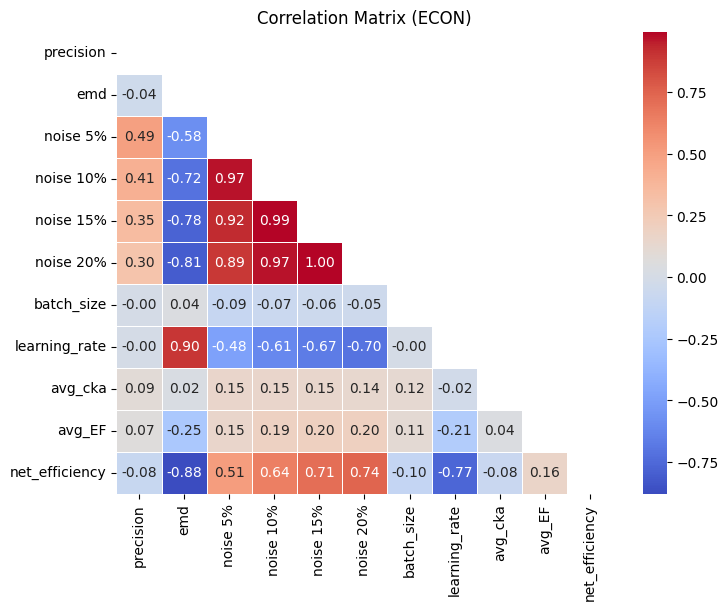

In [152]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix (ECON)')
plt.show()

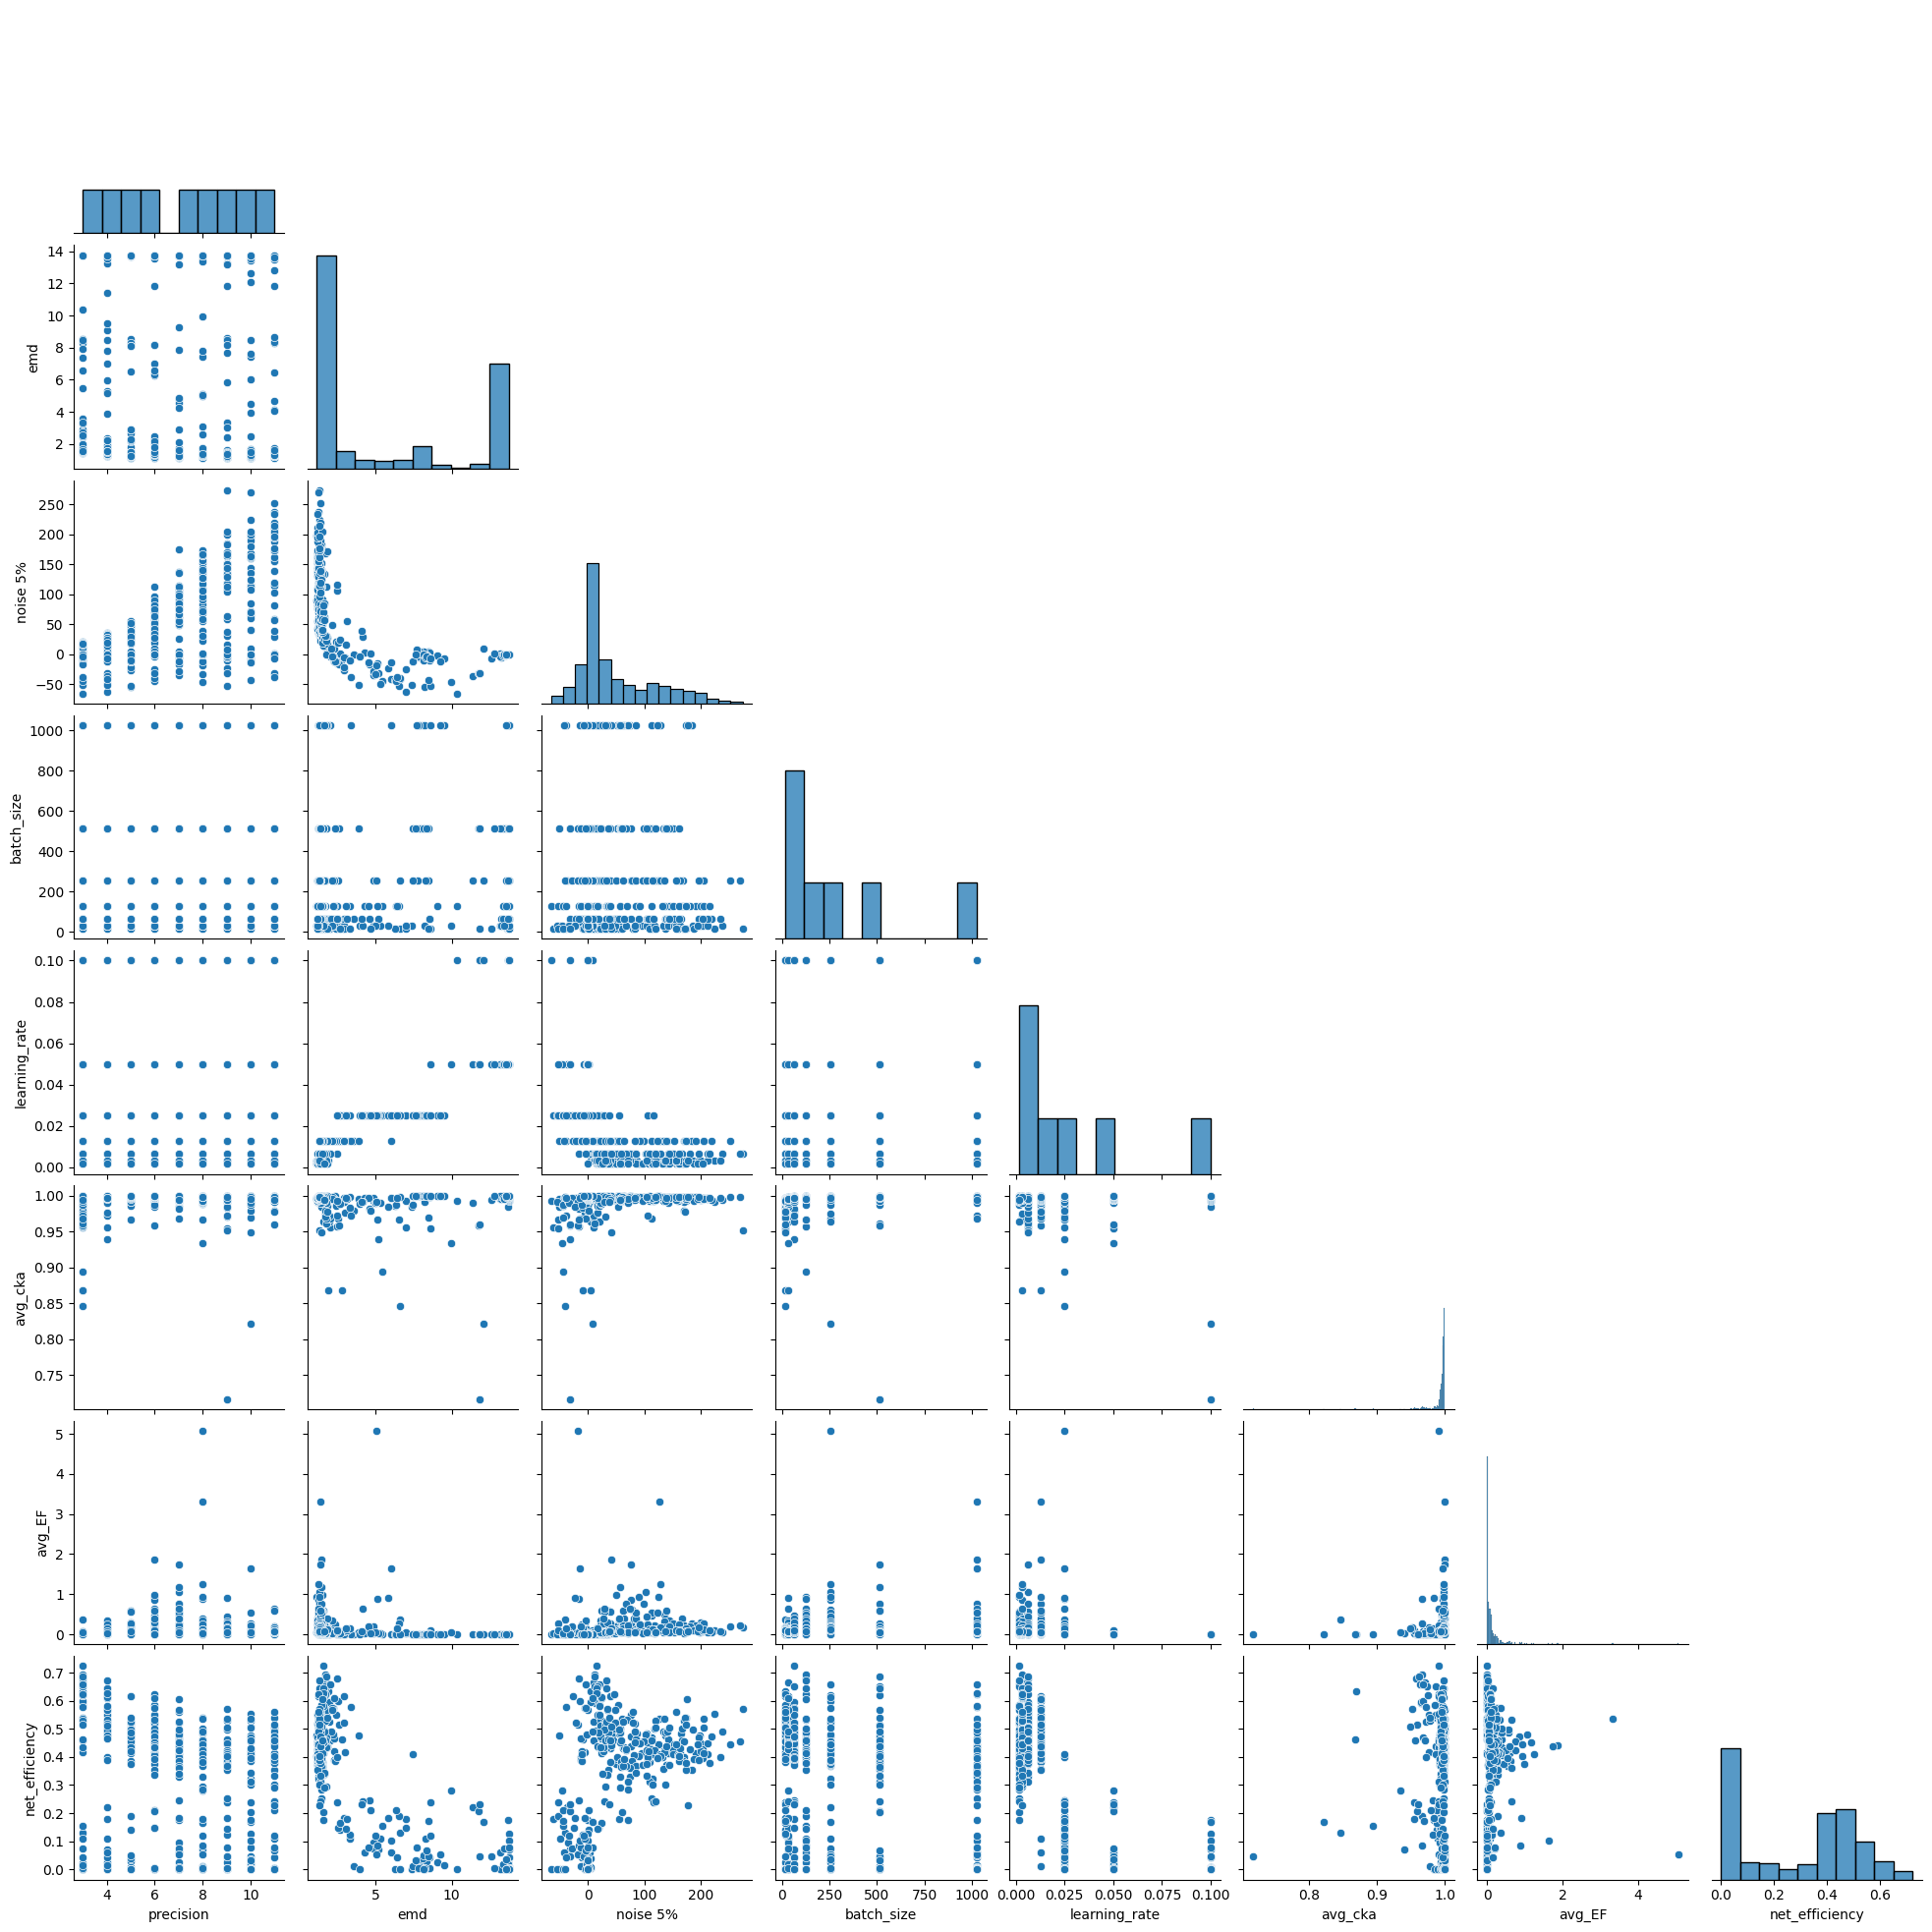

In [153]:
dataset_df.drop(columns=['noise 10%', 'noise 15%', 'noise 20%'], inplace=True)
sns.pairplot(dataset_df, corner=True)
plt.show()

# Effect of the quantization on the loss landscapes

In [154]:
DATA_PATH = '/home/jovyan/checkpoint/'

In [155]:
def get_loss_landscapes(batch_size, 
                        learning_rate, 
                        precision,
                        size, 
                        normalization,
                        steps, 
                        distance):
    '''
    Get the value of the Neural Efficiency
    '''
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/',
        f'plot_{normalization}_{steps}_{distance}.pkl'
    )
    try:
        f = open(path, "rb")
        data = pickle.load(f)
        f.close()
    except:
        print(path + ' Not found!')
        return False
    
    return data[f'plot_{normalization}_{steps}_{distance}']
    

In [158]:
BATCH_SIZE = 256
LEARNING_RATE = 0.003125
NORMALIZATION = 'filter'
STEPS = 200
DISTANCE = 150
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

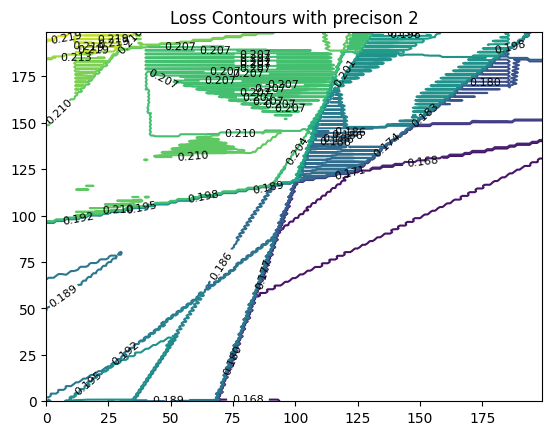

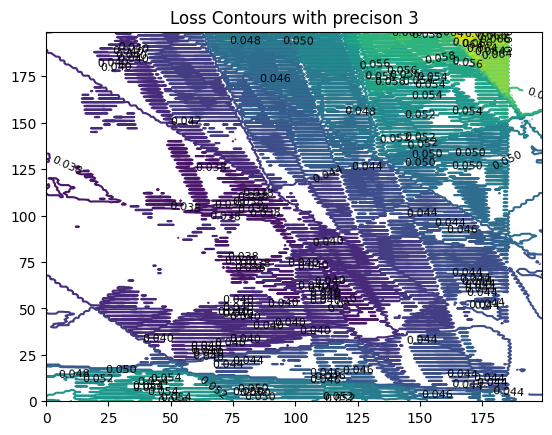

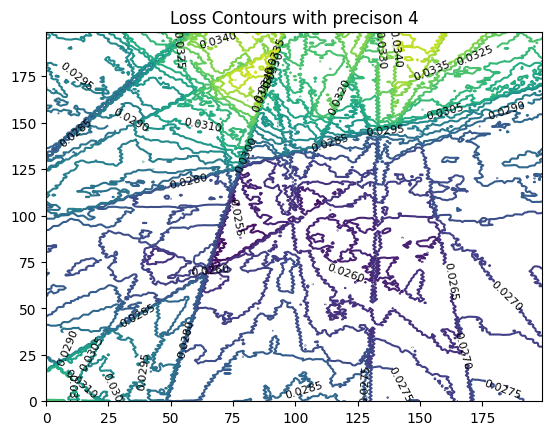

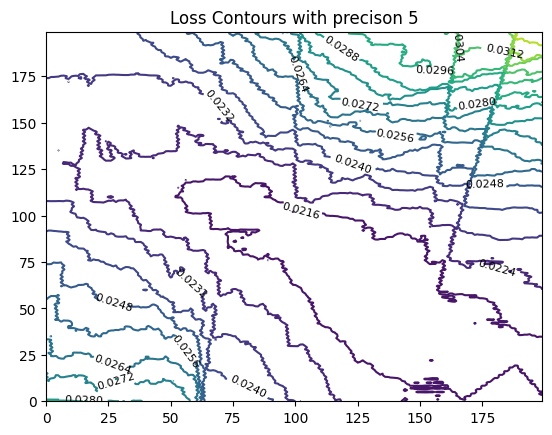

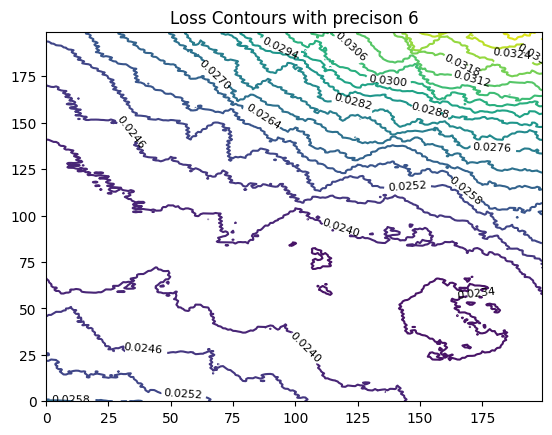

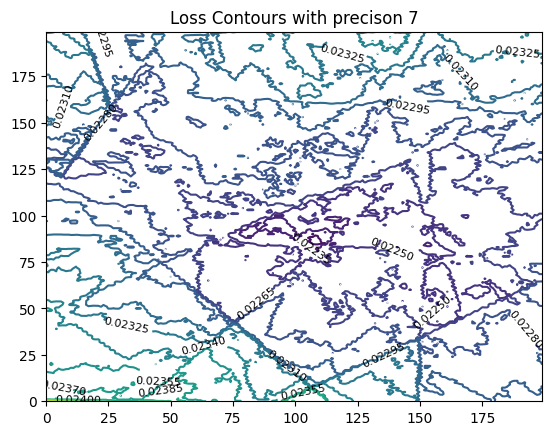

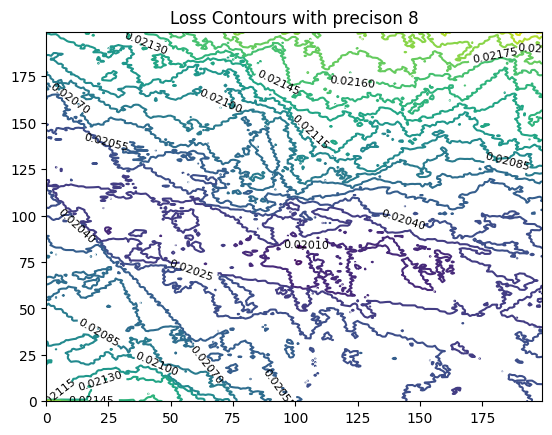

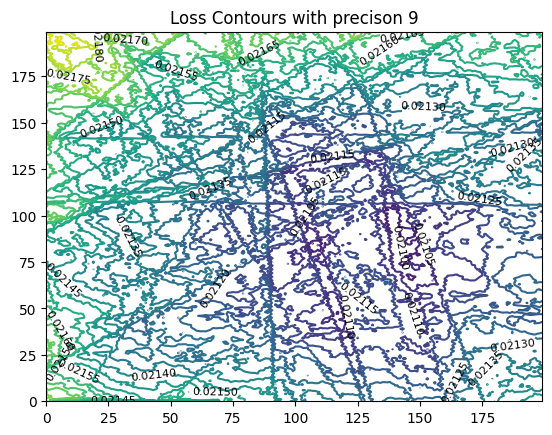

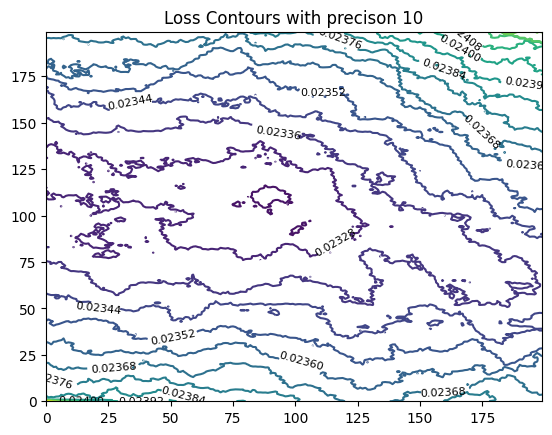

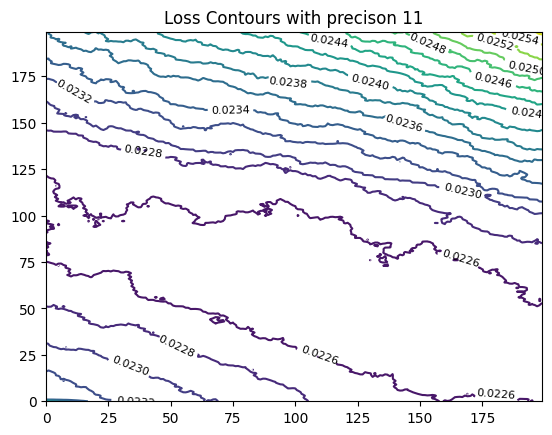

In [159]:
for p in precisions:
    data = get_loss_landscapes(BATCH_SIZE, LEARNING_RATE, p, 'baseline', NORMALIZATION, STEPS, DISTANCE)
    loss_data = data['points']
    # plot 2D
    plot = plt.contour(loss_data, levels=20)
    plt.clabel(plot, inline=True, fontsize=8, colors='black')
    plt.title(f'Loss Contours with precison {p}')
    plt.show()
    


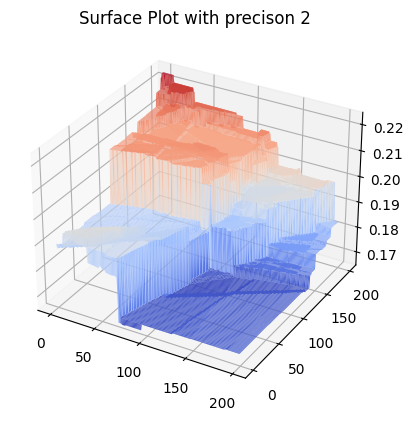

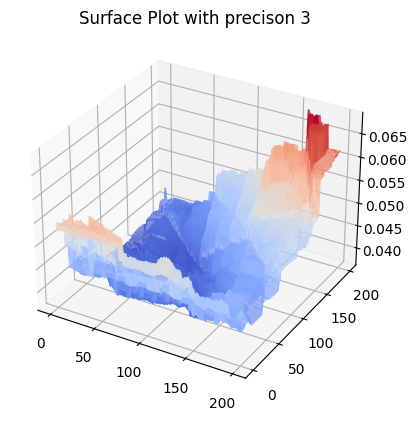

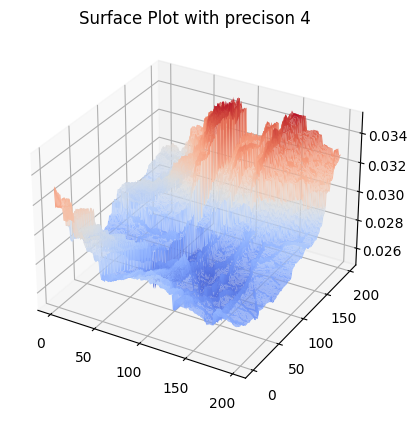

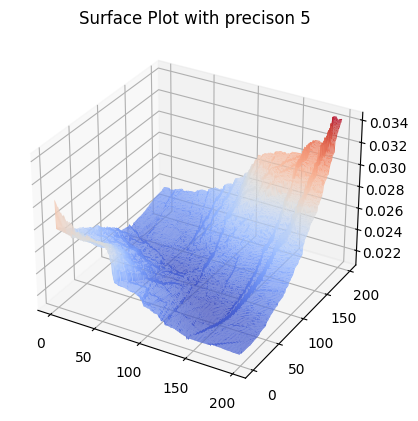

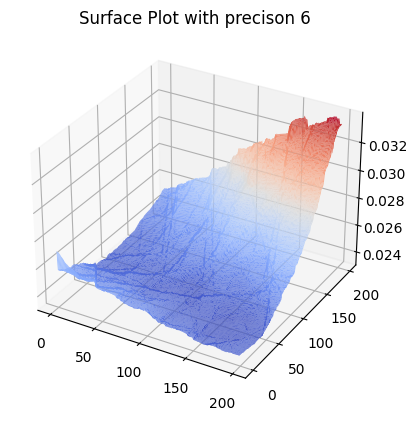

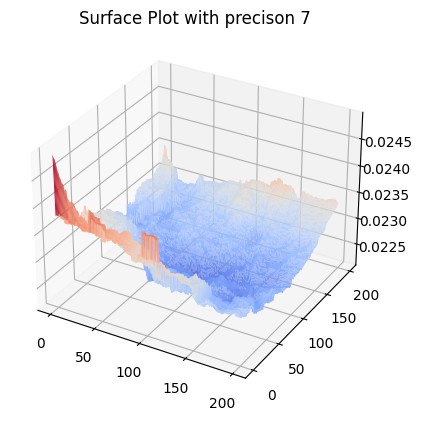

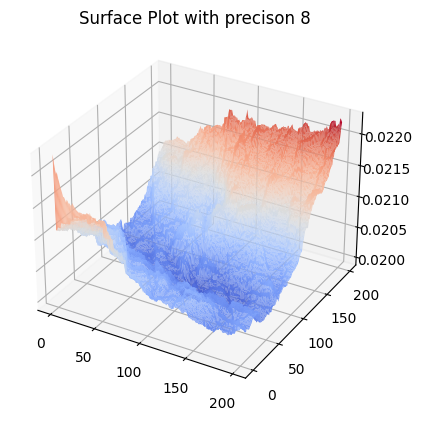

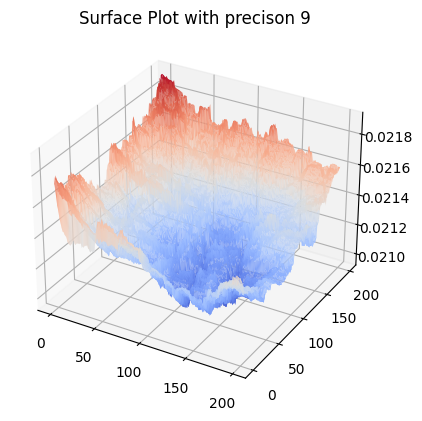

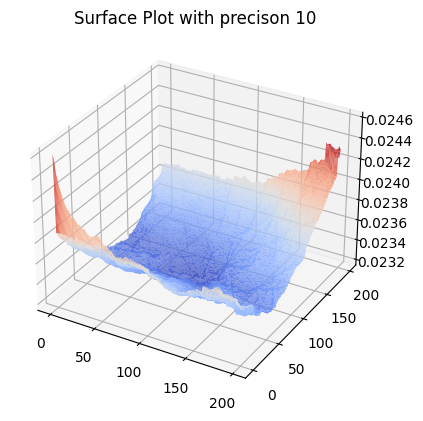

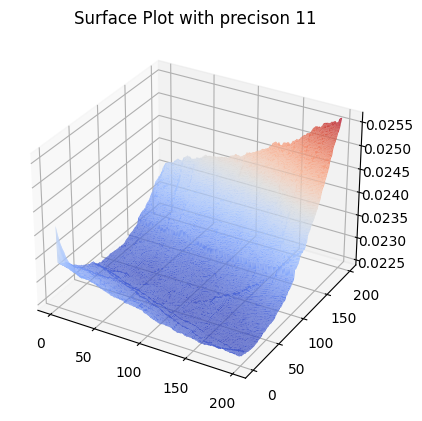

In [160]:
for p in precisions:
    data = get_loss_landscapes(BATCH_SIZE, LEARNING_RATE, p, 'baseline', NORMALIZATION, STEPS, DISTANCE)
    loss_data = data['points']    
    # #plot 3D
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
    Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
    ax.plot_surface(X, Y, loss_data, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_title(f'Surface Plot with precison {p}')
    fig.show()

# Features of the non-dominated solutions